# Visualização dos resultados
### Desempenho de algoritmos de classificação na detecção de intrusão em redes de dispositivos IoT

## Importação de bibliotecas

In [29]:
from pathlib import Path

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Constantes

In [30]:
CURRENT_DIR = Path.cwd()
PROJECT_DIR = CURRENT_DIR.parent if CURRENT_DIR.name == "src" else CURRENT_DIR
DATASET_DIRECTORY = PROJECT_DIR / "CICIoT2023"
DATA_DIR = PROJECT_DIR / "data"
FIGURES_DIR = PROJECT_DIR / "figures"
DEV = "dev"
PROD = "five_percent"

DATA_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

## Parâmetros

In [31]:
SAVE_PLOTS = True

FILES_SUFFIX = PROD
RESULTS_FILE = PROJECT_DIR / f"results_{FILES_SUFFIX}.csv"

## Análise dos Resultados

In [32]:
df = pd.read_csv(RESULTS_FILE)
df.drop_duplicates(inplace=True)
df["model"] = df["model"].replace(
    {
        "LogisticRegression": "Regressão Logística",
        "Perceptron": "Perceptron",
        "AdaBoostClassifier": "AdaBoost",
        "MLPClassifier": "DNN",
        "RandomForestClassifier": "Random Forest",
    }
)
df["duration_training"] = df["duration_training"] / 60
df = df.rename(
    columns={
        "accuracy_score": "Acurácia",
        "precision_score": "Precisão",
        "recall_score": "Recall",
        "f1_score": "F1",
        "duration_training": "Tempo de Treinamento",
    }
)
df.set_index("model", inplace=True)

features_groupby = df.groupby("num_features")
metrics = ["Acurácia", "Precisão", "Recall", "F1"]
all_metrics = ["Acurácia", "Precisão", "Recall", "F1", "Tempo de Treinamento"]

In [33]:
def make_legend(figure: matplotlib.figure.Figure):
    lr_patch = mpatches.Patch(color="#5b90b4", label="Regressão Logística")
    per_patch = mpatches.Patch(color="#e79a56", label="Perceptron")
    adb_patch = mpatches.Patch(color="#61a861", label="AdaBoost")
    dnn_patch = mpatches.Patch(color="#cc6465", label="DNN")
    rf_patch = mpatches.Patch(color="#a88ec1", label="Random Forest")
    line_patch = mpatches.Patch(color="slategray", label="Valores após seleção de features")
    figure.legend(
        handles=[lr_patch, per_patch, adb_patch, dnn_patch, rf_patch, line_patch],
        loc="lower center",
        ncol=6,
    )

### Métricas de desempenho

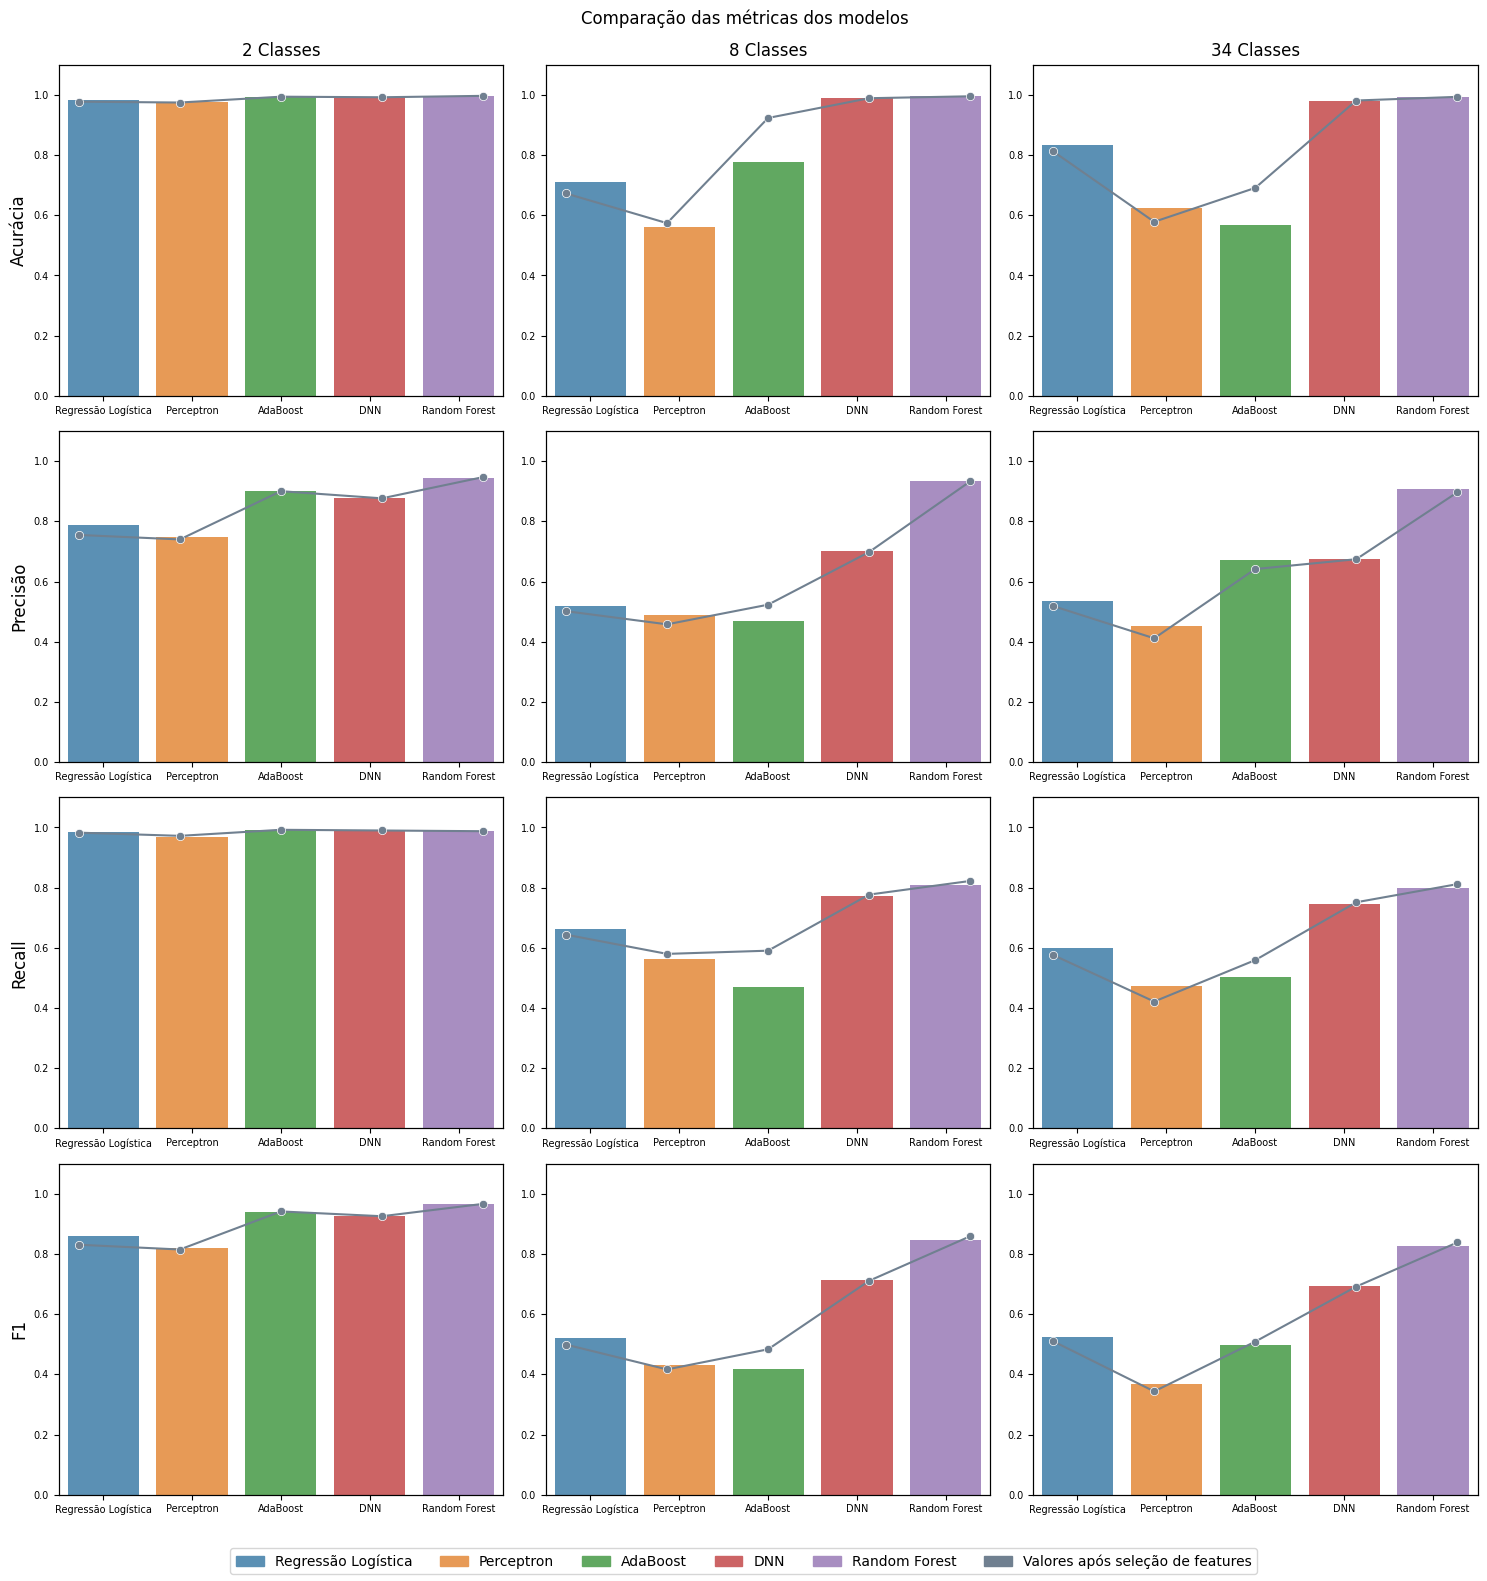

In [34]:
fig, axes = plt.subplots(
    len(metrics),
    len(features_groupby),
    figsize=(len(features_groupby) * 5, len(metrics) * 4),
)

for i, metric in enumerate(metrics):
    for j, (num_classes, df_feature) in enumerate(features_groupby):
        df_false = df_feature[~df_feature["feature_selection"]]
        df_true = df_feature[df_feature["feature_selection"]]

        ax = axes[i, j]

        sns.barplot(
            data=df_false,
            x="model",
            y=df_false[metric],
            hue="model",
            ax=ax,
            alpha=0.8,
        )
        new_ax = ax.twiny()
        sns.lineplot(
            data=df_true,
            x="model",
            y=df_true[metric],
            marker="o",
            markeredgewidth=0.5,
            color="slategray",
            ax=new_ax,
        )
        ax.grid(False)
        new_ax.grid(False)

        ax.set_xlabel("")
        ax.tick_params(axis="both", which="major", labelsize=7)
        ax.tick_params(axis="both", which="minor", labelsize=5)

        new_ax.get_xaxis().set_visible(False)

        ax.set_ylim(0, 1.1)
        new_ax.set_ylim(0, 1.1)

        if i == 0:
            ax.set_title(f"{num_classes} Classes")

        if j == 0:
            ax.set_ylabel(metric, size="large")
        else:
            ax.set_ylabel("")

make_legend(fig)
plt.suptitle("Comparação das métricas dos modelos")
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

if SAVE_PLOTS:
    fig.get_figure().savefig(
        fname=FIGURES_DIR / "performance_metrics.pdf", format="pdf"
    )

### Tempo de Treinamento

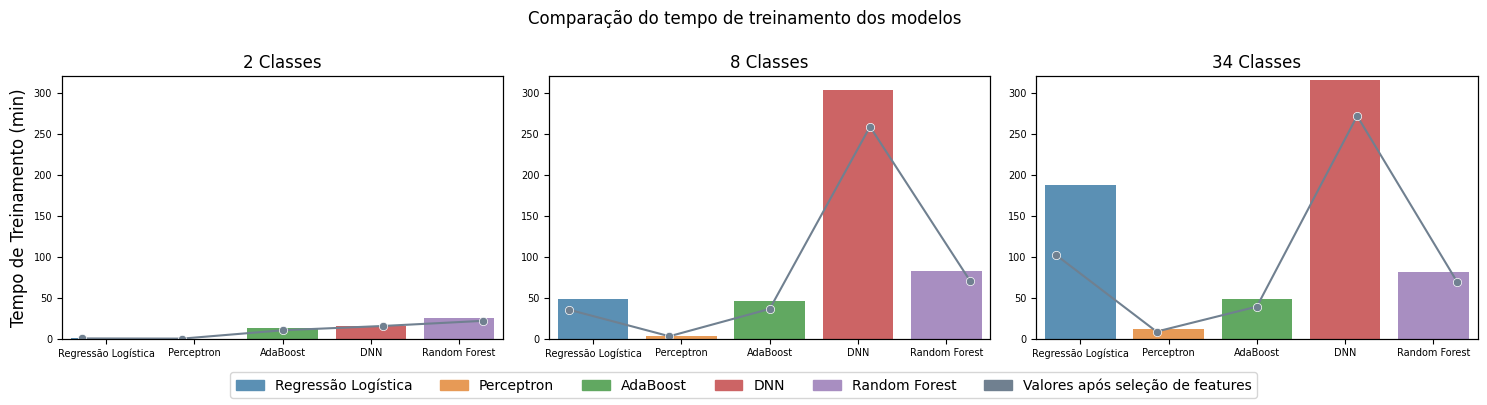

In [35]:
fig, axes = plt.subplots(
    1,
    len(features_groupby),
    figsize=(len(features_groupby) * 5, 4),
)

for i, (num_classes, df_feature) in enumerate(features_groupby):
    df_false = df_feature[~df_feature["feature_selection"]]
    df_true = df_feature[df_feature["feature_selection"]]
    ax = axes[i]
    sns.barplot(
        data=df_false,
        x="model",
        y=df_false["Tempo de Treinamento"],
        hue="model",
        ax=ax,
        alpha=0.8,
        errorbar=None,
    )
    new_ax = ax.twiny()
    sns.lineplot(
        data=df_true,
        x="model",
        y=df_true["Tempo de Treinamento"],
        marker="o",
        markeredgewidth=0.5,
        color="slategray",
        ax=new_ax,
        errorbar=None,
    )
    ax.grid(False)
    new_ax.grid(False)

    ax.set_xlabel("")
    ax.tick_params(axis="both", which="major", labelsize=7)
    ax.tick_params(axis="both", which="minor", labelsize=5)

    new_ax.get_xaxis().set_visible(False)

    ax.set_ylim(0, 320)
    new_ax.set_ylim(0, 320)

    ax.set_title(f"{num_classes} Classes")

    if i == 0:
        ax.set_ylabel("Tempo de Treinamento (min)", size="large")
    else:
        ax.set_ylabel("")


make_legend(fig)

plt.suptitle("Comparação do tempo de treinamento dos modelos")
plt.tight_layout(rect=[0, 0.07, 1, 0.99])
plt.show()

if SAVE_PLOTS:
    fig.get_figure().savefig(
        fname=FIGURES_DIR / "training_time.pdf", format="pdf"
    )